#### Following the blog here:
https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c

In [1]:
# imports 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

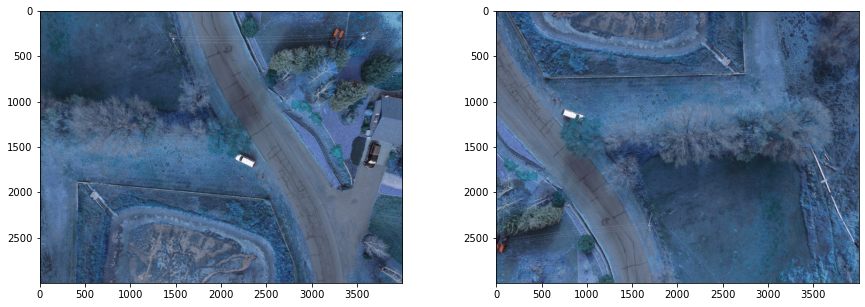

In [13]:
# data
image_1 = '../data/4th/DJI_0020.JPG'
image_2 = '../data/4th/DJI_0023.JPG'

# as array
image_1_array = cv2.imread(image_1)
image_2_array = cv2.imread(image_2)

# look at data 
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(image_1_array)
ax[1].imshow(image_2_array)

In [14]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)




In [15]:
kps1, feat1 = detectAndDescribe(image_1_array, method='sift')
kps2, feat2 = detectAndDescribe(image_2_array, method='sift')

In [16]:
kps1, feat1 = detectAndDescribe(image_1_array, method='sift')
kps2, feat2 = detectAndDescribe(image_2_array, method='sift')
pts1 = cv2.KeyPoint_convert(kps1)
pts2 = cv2.KeyPoint_convert(kps2)

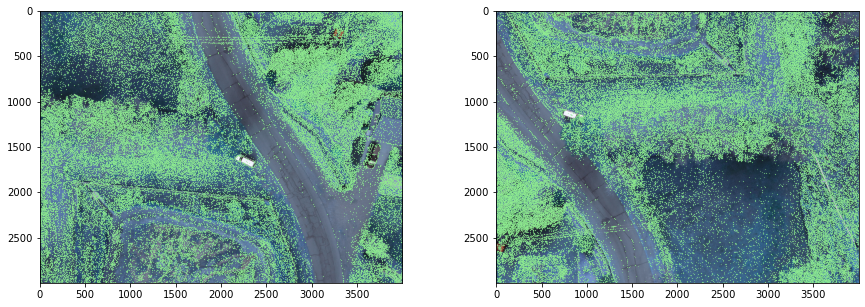

In [17]:
# look at the key points
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(image_1_array)
ax[1].imshow(image_2_array)

point_look = {'s':0.02, 'color':'lightgreen'}
ax[0].scatter(pts1[:,0], pts1[:,1], **point_look)
ax[1].scatter(pts2[:,0], pts2[:,1], **point_look)

In [18]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [19]:
matcher = createMatcher('sift', True)
matches = matcher.match(feat1, feat2)

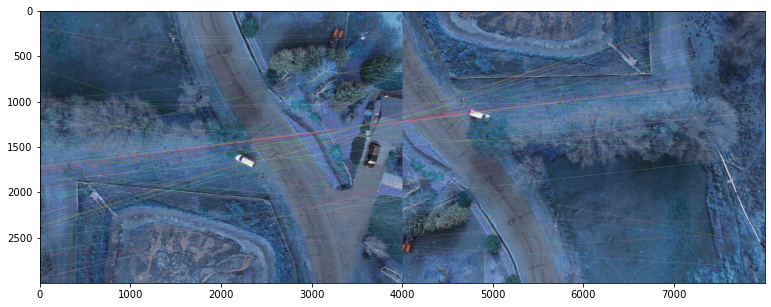

In [20]:
image_match = cv2.drawMatches(image_1_array, kps1, image_2_array, kps2, matches[:100], None, flags=2)
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.imshow(image_match)

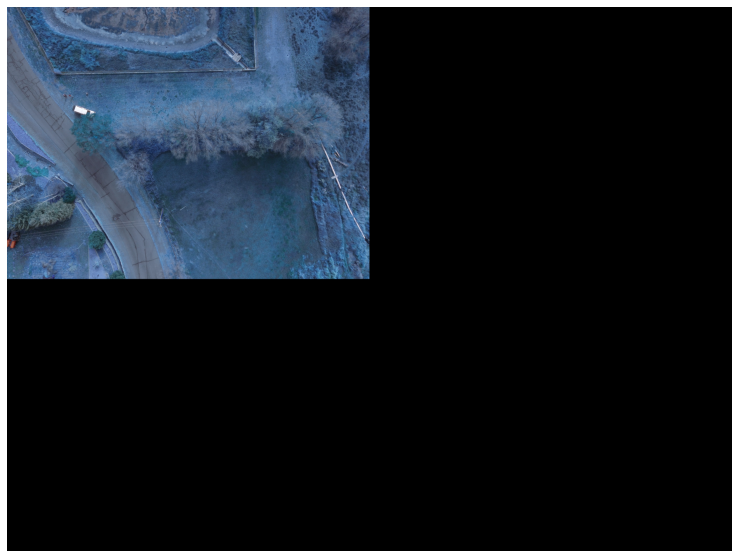

In [22]:
query_pts = np.array([kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2).astype(np.float32)
train_pts = np.array([kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2).astype(np.float32)
 
H = cv2.findHomography(query_pts, train_pts, cv2.RANSAC)
# Apply panorama correction
width = image_1_array.shape[1] + image_2_array.shape[1]
height = image_1_array.shape[0] + image_2_array.shape[0]
result = cv2.warpPerspective(image_1_array, H[0], (width, height))
result[0:image_2_array.shape[0], 0:image_2_array.shape[1]] = image_2_array

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

In [160]:
cv2.imwrite('../StitchedImage.png', result)

True

In [10]:
# Now try to integrate into an interative approach that adds on images to match



def image_stitcher(image_list:list, output_image:str='StitchedImageMany.png', dry_run:bool=False ) -> None:
    
    image_pairs = create_image_pairs(image_list, output_image)
    
    for pair in image_pairs:
        
        image_1, image_2 = pair
        
        print(f'stitching {image_1}, {image_2}')
        
        if not dry_run: 
            stitch_two_images(image_1,image_2,output_image)

            
def stitch_two_images(image_1, image_2, output_image):
    image_1_array = cv2.imread(image_1)
    image_2_array = cv2.imread(image_2)


    print(f'calculating key points using SIFT {image_1}, {image_2}')
    kps1, feat1 = detectAndDescribe(image_1_array, method='sift')
    kps2, feat2 = detectAndDescribe(image_2_array, method='sift')

    pts1 = cv2.KeyPoint_convert(kps1)
    pts2 = cv2.KeyPoint_convert(kps2)

    print(f'matching key points {image_1}, {image_2}')
    matcher = createMatcher('sift', True)
    matches = matcher.match(feat1, feat2)
    
    print(f'{len(matches)} matches found')

    query_pts = np.array([kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2).astype(np.float32)
    train_pts = np.array([kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2).astype(np.float32)

    print(f'calculating homography {image_1}, {image_2}')
    H = cv2.findHomography(query_pts, train_pts, cv2.RANSAC)
    print(H)
    # Apply panorama correction
    width = image_1_array.shape[1] + image_2_array.shape[1]
    height = image_1_array.shape[0] + image_2_array.shape[0]
    result = cv2.warpPerspective(image_1_array, H[0], (width, height))
    result[0:image_2_array.shape[0], 0:image_2_array.shape[1]] = image_2_array
    cv2.imwrite(output_image, result)

    print(f'clipping to threshold {output_image}')
    clip_to_threshold(output_image, output_image)
    
        
def create_image_pairs(image_list, output_image):
    pairs = []
    pairs.append([image_list[0],image_list[1]])
    if len(image_list) > 2:
        [pairs.append([output_image, image_list[idx]]) for idx in range(2,len(image_list))]
        
    return pairs


def clip_to_threshold(image_in:str, image_out:str):
    
    # read in
    image_array = cv2.imread(image_in)
    # convert to grayscale and threshold
    grayscale = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.threshold(grayscale, 0, 255, cv2.THRESH_OTSU)
    # clip to bbox
    bbox = cv2.boundingRect(thresholded[1])
    x, y, w, h = bbox
    print(f'clipping image to bounding box:{bbox}')
    foreground = image_array[y:y+h, x:x+w]
    print(f'saving image to: {image_out}')
    cv2.imwrite(image_out, foreground)
       
        
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf 


def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

    

In [11]:
stitch_two_images('../data/4th/DJI_0020.JPG', '../data/4th/DJI_0023.JPG', 'rotationtest.png')

calculating key points using SIFT ../data/4th/DJI_0020.JPG, ../data/4th/DJI_0023.JPG
matching key points ../data/4th/DJI_0020.JPG, ../data/4th/DJI_0023.JPG
43174 matches found
calculating homography ../data/4th/DJI_0020.JPG, ../data/4th/DJI_0023.JPG
(array([[-9.62224418e-01, -1.51174519e-01,  3.26091341e+03],
       [ 1.18706927e-01, -1.01043454e+00,  2.50633340e+03],
       [ 6.70578873e-06, -3.35924766e-05,  1.00000000e+00]]), array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8))
clipping to threshold rotationtest.png


In [3]:
image_list = [
    'Stitched_Big_Image4.png',
    '../data/4th/DJI_0021.JPG',
    '../data/4th/DJI_0022.JPG',
    '../data/4th/DJI_0023.JPG',
    '../data/4th/DJI_0024.JPG',
    '../data/4th/DJI_0025.JPG',
    '../data/4th/DJI_0026.JPG',
    '../data/4th/DJI_0027.JPG',
    '../data/4th/DJI_0028.JPG',
    '../data/4th/DJI_0029.JPG',
    '../data/4th/DJI_0030.JPG',
    '../data/4th/DJI_0031.JPG',
    '../data/4th/DJI_0032.JPG',
    '../data/4th/DJI_0033.JPG',
    '../data/4th/DJI_0034.JPG',
    '../data/4th/DJI_0035.JPG',
    '../data/4th/DJI_0036.JPG',
             ]
image_stitcher(image_list, 'Stitched_Big_Image5.png', dry_run=True)


stitching Stitched_Big_Image4.png, ../data/4th/DJI_0021.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0022.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0023.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0024.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0025.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0026.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0027.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0028.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0029.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0030.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0031.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0032.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0033.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0034.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0035.JPG
stitching Stitched_Big_Image5.png, ../data/4th/DJI_0036.JPG


In [30]:
from exif import Image

In [33]:
img_path = '../Data/4th/DJI_0025.JPG'

with open(img_path, "rb") as src:
    img = Image(src)

In [39]:
img.get_all()

/opt/homebrew/Caskroom/miniforge/base/envs/image-stitch/lib/python3.8/site-packages/exif/_image.py:183: RuntimeWarning: ASCII tag contains 26 fewer bytes than specified
  tag_value = self.__getattr__(tag_name)
/opt/homebrew/Caskroom/miniforge/base/envs/image-stitch/lib/python3.8/site-packages/exif/_image.py:183: RuntimeWarning: ASCII tag contains 23 fewer bytes than specified
  tag_value = self.__getattr__(tag_name)
/opt/homebrew/Caskroom/miniforge/base/envs/image-stitch/lib/python3.8/site-packages/exif/_image.py:183: RuntimeWarning: ASCII tag contains 12 fewer bytes than specified
  tag_value = self.__getattr__(tag_name)
unable to read tag 'components_configuration'
unable to read tag 'maker_note'
unable to read tag 'flashpix_version'
unable to read tag '_interoperability_ifd_Pointer'
unable to read tag 'file_source'
unable to read tag 'scene_type'
unable to read tag 'device_setting_description'


{'image_description': 'DCIM\\100MEDIA\\DJI_0025.JPG',
 'make': 'DJI',
 'model': 'FC300S',
 'orientation': <Orientation.TOP_LEFT: 1>,
 'x_resolution': 72.0,
 'y_resolution': 72.0,
 'resolution_unit': <ResolutionUnit.INCHES: 2>,
 'software': 'v01.23.4920',
 'datetime': '2017:11:14 13:11:06',
 'y_and_c_positioning': 1,
 '_exif_ifd_pointer': 182,
 '_gps_ifd_pointer': 686,
 'xp_comment': '0.9.138\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'xp_keywords': 'N\x00\x00\x00\x00\x00\x00',
 'compression': 6,
 'jpeg_interchange_format': 41972,
 'jpeg_interchange_format_length': 8383,
 'exposure_time': 0.001791,
 'f_number': 2.8,
 'exposure_program': <ExposureProgram.NORMAL_PROGRAM: 2>,
 'photographic_sensitivity': 100,
 'exif_version': '0230',
 'datetime_original': '2017:11:14 13:11:06',
 'datetime_digitized': '2017:11

In [ ]:
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * direction[new_dir]



In [48]:
def coordinate_convert(latitude, latitude_ref, longitude, longitude_ref):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    latitude_new = direction[latitude_ref] * (latitude[0] + latitude[1]/60 + latitude[2]/3600)
    longitude_new = direction[longitude_ref] * (longitude[0] + longitude[1]/60 + longitude[2]/3600)
    
    return latitude_new, longitude_new

def infer_image_extent(image):
    

In [49]:
coordinate_convert(img.gps_latitude, img.gps_latitude_ref, img.gps_longitude, img.gps_longitude_ref )

(38.90240211111111, -107.9200441388889)

In [44]:
stitcher = cv2.Stitcher_create()
image_list = [f'../Data/DroneImagesAerial/{i}' for i in os.listdir('../Data/DroneImagesAerial/')]
images = [cv2.imread(im) for im in image_list]

In [45]:
(status, stitched) = stitcher.stitch(images)
cv2.imwrite('outputStitcherclass3.png', stitched)

error: OpenCV(4.5.3) /Users/runner/miniforge3/conda-bld/libopencv_1633800924777/work/modules/imgcodecs/src/loadsave.cpp:803: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [ ]:
plt.imshow(stitched)

In [43]:
cv2.imwrite('outputStitcherclass2.png', stitched)

True

### Open SFM

https://opensfm.org/

In [ ]:
cv2.Sf